# Andres Graterol - 4031393 - Fall 22
# Homework 6

In [1]:
from sklearn.datasets import load_digits, make_blobs
import matplotlib.pyplot as plt
import random as rnd
import numpy as np
import math

## Problem 1

In [2]:
def computeCovarMatrix(data):
    data_size = len(data)

    # Final size should be (64,64)
    summation = np.zeros((64,64))
    for i, image in enumerate(data):
        image = np.expand_dims(image, axis=1)
        #print(np.array(image).shape)
        #print(np.array(np.transpose(image).shape))
        temp = np.matmul(image, np.transpose(image))
        summation = np.add(summation, temp)

    #print("Shape of summation: ", np.array(summation).shape)
    covar_matrix = summation / data_size

    return covar_matrix

def findPrincipalComponents(covar_matrix):
    # The eigenvalues and eigenvectors 
    # vectors columns correspond to the eigen values
    values, vectors = np.linalg.eig(covar_matrix)

    eigenvalue_indices = np.argsort(values)[::-1]
    largest_eigenvalues = np.sort(values)[::-1]

    pc_eigenvalues = largest_eigenvalues[:1]
    pc_eigenvectors = []
    pc_eigenvectors.append(vectors[:,eigenvalue_indices[0]])
    pc_eigenvectors.append(vectors[:,eigenvalue_indices[1]])
    pc_eigenvectors = np.transpose(pc_eigenvectors)

    return pc_eigenvalues, pc_eigenvectors

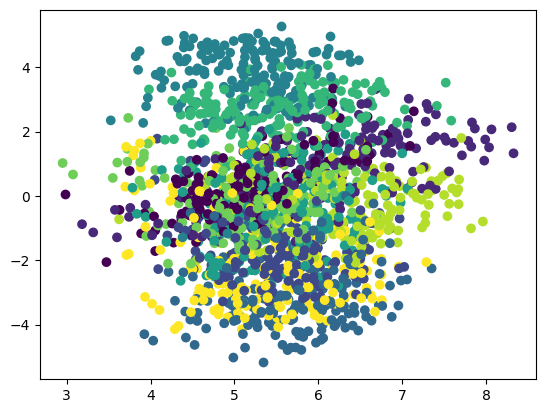

In [3]:
# Can view some of the images using the imshow function of matplotlib.pyplot
digits = load_digits()
data, labels = digits.data, digits.target

# Normalize the data 
data -= np.mean(data)
data /= np.std(data)

covar_matrix = computeCovarMatrix(data)
pc_eigenvalues, pc_eigenvectors = findPrincipalComponents(covar_matrix)
dataproj = np.matmul(data, pc_eigenvectors)

plt.scatter(dataproj[:, 0], dataproj[:, 1], c=labels)

## BONUS

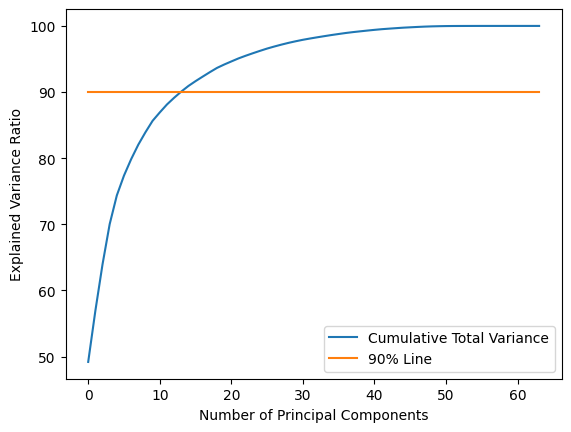

Components needed to keep 90% of variance:  [12]


In [17]:
# Calculating and sorting the eigenvectors and values again
values, vectors = np.linalg.eig(covar_matrix)
eigenvalue_indices_desc = np.argsort(values)[::-1]
eigenvalues_desc = np.sort(values)[::-1]

total = sum(eigenvalues_desc)
explained_var = [(i/total)*100 for i in eigenvalues_desc]
cumulative_explained_var = np.cumsum(explained_var)

x = np.arange(0, len(covar_matrix))

intersect = np.argwhere(np.diff(np.sign(cumulative_explained_var - [90 for i in x]))).flatten()

plt.plot(x, cumulative_explained_var, label='Cumulative Total Variance')
plt.plot(x, [90 for i in x], label = '90% Line')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.legend(loc='best')
plt.show()

print("Components needed to keep 90% of variance: ", x[intersect])

## Problem 2

In [36]:
# Plot the data 
def plotClusters(initial_centers, final_centers, dataset, assignments):
    plt.scatter(dataset[:,0], dataset[:,1], c=assignments)
    first_centers = plt.scatter(initial_centers[:,0], initial_centers[:,1], marker='x', color='m')
    last_centers = plt.scatter(final_centers[:,0], final_centers[:,1], marker='x', color= 'k')
    plt.legend((first_centers, last_centers),
                ('Initial Centers', 'Final Centers'), 
                loc='upper right',
                fontsize=8)
    plt.show()

In [37]:
def computeNewCenters(data, assignments):
    clusterMembers = []
    for i in range(4):
        indices =  np.where(np.array(assignments) == i)
        datapoints = data[indices]
        clusterMembers.append(datapoints)

    # Get the number in each cluster 
    # Want this to be of length 4
    points_per_cluster = []
    for i in range(len(clusterMembers)):
        points_per_cluster.append(len(clusterMembers[i]))

    #print("Shape of points per cluster:", len(points_per_cluster))
    #print("Cluster members:", clusterMembers)

    # Get the sum for each cluster
    cluster_totals = [] 
    for i in range(len(clusterMembers)):
        cluster_sum = np.zeros((2,))
        for j, point in enumerate(clusterMembers[i]):
            cluster_sum = np.add(cluster_sum, point)    

        cluster_totals.append(cluster_sum)
         
    #print("Shape of cluster sums: ", np.array(cluster_totals).shape)

    # Calculate the new centers
    # Shape of (4, 2)
    new_centers = []
    for i in range(4):
        # Find and append the mean of each cluster
        new_centers.append(cluster_totals[i]/points_per_cluster[i])

    #print("Our new centers:", new_centers, "and shape: ", np.array(new_centers).shape)

    return new_centers

def computeClusterAssignments(centers, dataset):
    # WANT THIS TO BE 1000, 4
    distance_matrix = []
    for i, point in enumerate(dataset):
        point_distances = []
        for j, center in enumerate(centers):
            distance = math.dist(point, center)
            point_distances.append(distance)
        
        distance_matrix.append(point_distances)
    
    #print("Shape of the distance matrix:", np.array(distance_matrix).shape)

    # WANT THIS TO BE 1000, 1
    assignments = []
    for i, point in enumerate(distance_matrix):
        minDist = float('inf')
        for j, distance in enumerate(point):
            if distance < minDist:
                minDist = distance
        
        # Append the index of the min distance, this maps to the cluster
        assignments.append(point.index(minDist))

    assignments = np.array(assignments)
    #print("Shape of the cluster assignments: ", assignments.shape)

    return assignments


In [38]:
def kmeans_algorithm(centers, dataset):
    assignments = computeClusterAssignments(centers, dataset)
    iteration = 1

    new_assignments = np.zeros((1000,))
    # Exit the loop if the cluster assignments are no longer changing
    while(1):
        #print("Iteration: ", iteration)
        
        new_centers = computeNewCenters(dataset, assignments)

        # Compute assigments again with new centers
        new_assignments = computeClusterAssignments(new_centers, dataset)
        
        # If cluster assignments do not change, then we have converged!
        if (np.array_equal(new_assignments, assignments)):
            return new_centers, iteration, new_assignments, assignments
        
        assignments = new_assignments

        iteration += 1
            

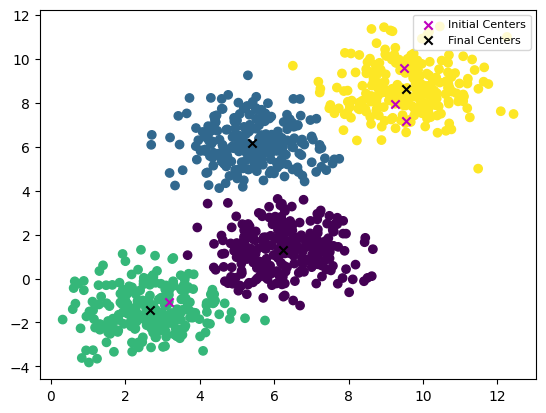

Iterations needed to converge:  9


In [46]:
# Here X contains the generated samples
# y contains the labels for cluster membership for each sample
X, y = make_blobs(centers=4, n_samples=1000)
#print(X.shape)

initial_centers = rnd.choices(X, k=4)
#print("My center choices:", initial_centers)
#print("Centers shape: ", np.array(initial_centers).shape)

final_centers, final_iterations, new_assignments, assignments = kmeans_algorithm(initial_centers, X)

initial_centers = np.array(initial_centers)
final_centers = np.array(final_centers)
plotClusters(initial_centers, final_centers, X, assignments)
print("Iterations needed to converge: ", final_iterations)

The number of iterations it takes to converge is highly variable as Kmeans clustering is very much dependent on where the cluster centers are initialized. 